In [1]:
import random
import cv2
import numpy as np
import os

In [2]:
original_data_path = "data/food11"
augmented_data_path = "data/food11_augmented"

In [3]:
### ONLY RUN IF THE AUGMENTED DATA DOES NOT EXIST YET ###

# Adding randomly generated date stamps on the images
for dir in os.listdir(original_data_path):
    print(dir)
    for dir2 in os.listdir(original_data_path + "/" + dir):
        print(dir2)
        for file in os.listdir(original_data_path + "/" + dir + "/" + dir2):
            img = cv2.imread(original_data_path + "/" + dir + "/" + dir2 + "/" + file)
            img = cv2.resize(img, (128, 128))
            cv2.putText(img, str(random.randint(1, 31)), (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2)
            cv2.putText(img, str(random.randint(1, 12)), (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2)
            cv2.putText(img, str(random.randint(2010, 2020)), (10, 90), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2)
            cv2.imwrite(augmented_data_path + "/" + dir + "/" + dir2 + "/" + file, img)

evaluation
Egg
Vegetable-Fruit
Seafood
Dessert
Noodles-Pasta
Soup
Meat
Fried food
Dairy product
Bread
Rice
training
Egg
Vegetable-Fruit
Seafood
Dessert
Noodles-Pasta
Soup
Meat
Fried food
Dairy product
Bread
Rice
validation
Egg
Vegetable-Fruit
Seafood
Dessert
Noodles-Pasta
Soup
Meat
Fried food
Dairy product
Bread
Rice


In [8]:
import keras
from keras import layers
from keras import regularizers

encoding_dim = 256

input_img = keras.Input(shape=(128*128*3,))
encoded = layers.Dense(encoding_dim, activation='relu',
                activity_regularizer=regularizers.l1(10e-5))(input_img)
encoded = layers.Dense(encoding_dim*2, activation='relu')(encoded)
encoded = layers.Dense(encoding_dim, activation='relu')(encoded)

decoded = layers.Dense(encoding_dim//2, activation='sigmoid')(encoded)
decoded = layers.Dense(encoding_dim, activation='sigmoid')(decoded)
decoded = layers.Dense(128*128*3, activation='sigmoid')(decoded)

autoencoder = keras.Model(input_img, decoded)

encoder = keras.Model(input_img, encoded)

encoded_input = keras.Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1]
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Load the data | first 100 images per class
data = []
labels = []
for dir in os.listdir(augmented_data_path + "/training"):
    print(dir)
    counter = 0
    for file in os.listdir(augmented_data_path + "/training/" + dir):
        img = cv2.imread(augmented_data_path + "/training/" + dir + "/" + file)
        img = cv2.resize(img, (128, 128))
        data.append(img)
        labels.append(dir)
        counter += 1
        if counter == 100:
            break

data = np.array(data)
labels = np.array(labels)

# Shuffle the data
shuffle = list(zip(data, labels))
random.shuffle(shuffle)
data, labels = zip(*shuffle)

x_train = np.array(data)
y_train = np.array(labels)

validation_data = []
validation_labels = []
for dir in os.listdir(augmented_data_path + "/validation"):
    print(dir)
    counter = 0
    for file in os.listdir(augmented_data_path + "/validation/" + dir):
        img = cv2.imread(augmented_data_path + "/validation/" + dir + "/" + file)
        img = cv2.resize(img, (128, 128))
        validation_data.append(img)
        validation_labels.append(dir)
        counter += 1
        if counter == 80:
            break

validation_data = np.array(validation_data)
validation_labels = np.array(validation_labels)

# Shuffle the data
shuffle = list(zip(validation_data, validation_labels))
random.shuffle(shuffle)
validation_data, validation_labels = zip(*shuffle)

x_test = np.array(validation_data)
y_test = np.array(validation_labels)

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

Egg
Vegetable-Fruit
Seafood
Dessert
Noodles-Pasta
Soup
Meat
Fried food
Dairy product
Bread
Rice
Egg
Vegetable-Fruit
Seafood
Dessert
Noodles-Pasta
Soup
Meat
Fried food
Dairy product
Bread
Rice
(1100, 49152)
(880, 49152)


In [11]:
autoencoder.fit(x_train, x_train,
                epochs=150,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))


Epoch 1/150
5/5 [==============================] - 5s 800ms/step - loss: 0.6872 - val_loss: 0.6692
Epoch 2/150
5/5 [==============================] - 4s 761ms/step - loss: 0.6633 - val_loss: 0.6563
Epoch 3/150
5/5 [==============================] - 4s 732ms/step - loss: 0.6554 - val_loss: 0.6549
Epoch 4/150
5/5 [==============================] - 4s 736ms/step - loss: 0.6536 - val_loss: 0.6520
Epoch 5/150
5/5 [==============================] - 4s 734ms/step - loss: 0.6509 - val_loss: 0.6505
Epoch 6/150
5/5 [==============================] - 4s 731ms/step - loss: 0.6501 - val_loss: 0.6501
Epoch 7/150
5/5 [==============================] - 4s 759ms/step - loss: 0.6497 - val_loss: 0.6496
Epoch 8/150
5/5 [==============================] - 4s 762ms/step - loss: 0.6493 - val_loss: 0.6494
Epoch 9/150
5/5 [==============================] - 4s 741ms/step - loss: 0.6491 - val_loss: 0.6493
Epoch 10/150
5/5 [==============================] - 4s 737ms/step - loss: 0.6490 - val_loss: 0.6492
Epoch 11/

In [12]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

28/28 [==============================] - 0s 13ms/step


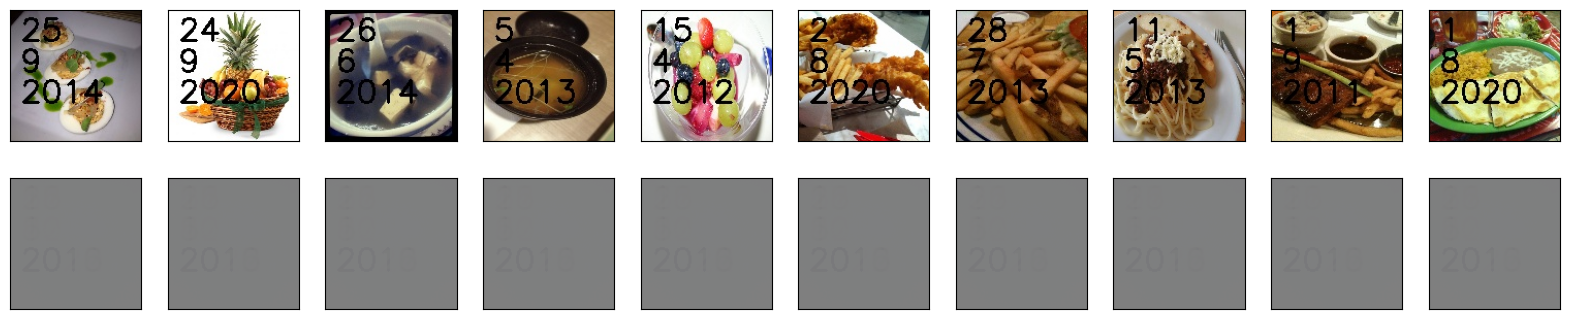

In [14]:
import matplotlib.pyplot as plt

n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    original_picture = x_test[i].reshape(128, 128, 3)
    original_picture = cv2.cvtColor(original_picture, cv2.COLOR_BGR2RGB)
    plt.imshow(original_picture)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    reconstructed_picture = decoded_imgs[i].reshape(128, 128, 3)
    reconstructed_picture = cv2.cvtColor(reconstructed_picture, cv2.COLOR_BGR2RGB)
    plt.imshow(reconstructed_picture)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()